# Tutorial 05: Doppler Effect Analysis and Compensation

This tutorial explores the Doppler effect in satellite radio astronomy observations using the RSC-SIM framework. It covers:

1. Analyzing Doppler shifts in satellite trajectories
2. Calculating radial velocities and frequency shifts
3. Multi-satellite Doppler effect statistics
4. Risk-based Doppler compensation strategies
5. Physics-based frequency-domain correction

## Learning Objectives:
- Understand how satellite motion affects observed frequencies
- Learn to calculate and visualize Doppler shifts
- Explore statistical analysis of Doppler effects across constellations
- Implement risk-based decision making for Doppler compensation
- Apply physics-based frequency correction techniques

## Key Concepts:
- Radial velocity calculation from trajectory data
- Doppler shift computation: Δf = (v_r/c) * f_0
- Multi-channel frequency analysis
- Contamination probability assessment
- Frequency-domain Doppler correction

## Prerequisites:
- Tutorials 01-04 (basic observation, satellite interference, sky mapping, PSD analysis)
- Understanding of satellite orbital mechanics
- Familiarity with frequency domain concepts

## Output Files:
- `05_doppler_effect_analysis_standalone.png`: Detailed analysis for single satellite
- `05_doppler_effect_summary_standalone.png`: Summary across multiple satellites
- `05_doppler_compensation_result.png`: Result with/without Doppler correction


## Import Required Libraries

First, we need to import the necessary libraries and set up the Python path to access the RSC-SIM modules.


In [3]:
import sys
import os
from datetime import timedelta
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Add the src directory to the Python path
sys.path.insert(0, '/Users/lkruczek/Documents/SpectrumX/github/flagship2/RSC-SIM/src')

# Add the modular_tutorials directory to the Python path
sys.path.insert(0, '/Users/lkruczek/Documents/SpectrumX/github/flagship2/RSC-SIM/modular_tutorials')

# Import required modules
from radio_types import Antenna, Instrument
from astro_mdl import antenna_mdl_ITU
from sat_mdl import get_doppler_impact_on_observation

# Import additional modules needed for Doppler compensation
from radio_types import Observation, Constellation, Trajectory
from astro_mdl import (
    estim_casA_flux, power_to_temperature, temperature_to_power,
    estim_temp
)
from sat_mdl import (
    sat_link_budget_vectorized, lnk_bdgt_with_doppler_correction,
    calculate_radial_velocities_vectorized, analyze_doppler_statistics,
    print_doppler_statistical_summary
)
from obs_mdl import model_observed_temp
import antenna_pattern

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


================================================================================
STANDALONE DOPPLER EFFECT TEST
================================================================================

Setup and Configuration

We'll start by setting up the configuration parameters for our Doppler effect analysis.


In [4]:
print("="*80)
print("STANDALONE DOPPLER EFFECT TEST")
print("="*80)

# Get the directory where this script is located
script_dir = os.path.dirname(os.path.abspath('__file__'))

# Time window configuration
start_window = "2025-02-18T15:00:00.000"
stop_window = "2025-02-18T15:45:00.000"

# Replace colon with underscore for filename
start_window_str = start_window.replace(":", "_")
stop_window_str = stop_window.replace(":", "_")

# Observation parameters
dateformat = "%Y-%m-%dT%H:%M:%S.%f"
start_obs = datetime.strptime("2025-02-18T15:30:00.000", dateformat)
stop_obs = datetime.strptime("2025-02-18T15:40:00.000", dateformat)

# Frequency parameters
cent_freq = 11.325e9  # in Hz
bw = 1e3  # in Hz
freq_chan = 1

# Multi-channel parameters for PSD analysis
new_freq_chan = 164
new_bw = 30e6

print("✓ Configuration parameters set")
print(f"  - Time window: {start_window} to {stop_window}")
print(f"  - Observation period: {start_obs} to {stop_obs}")
print(f"  - Center frequency: {cent_freq/1e9:.3f} GHz")
print(f"  - Bandwidth: {bw/1e3:.1f} kHz")
print(f"  - Multi-channel: {new_freq_chan} channels, {new_bw/1e6:.0f} MHz")


STANDALONE DOPPLER EFFECT TEST
✓ Configuration parameters set
  - Time window: 2025-02-18T15:00:00.000 to 2025-02-18T15:45:00.000
  - Observation period: 2025-02-18 15:30:00 to 2025-02-18 15:40:00
  - Center frequency: 11.325 GHz
  - Bandwidth: 1.0 kHz
  - Multi-channel: 164 channels, 30 MHz


## Step 1: Load Satellite Trajectory Data

We'll load the satellite trajectory data and prepare it for Doppler analysis.


In [ ]:
print("\nStep 1: Loading satellite trajectory data...")

# Load satellite trajectories
file_traj_sats_path = os.path.join(
    os.path.dirname(os.path.abspath('__file__')), "..", "tutorial", "data",
    f"Starlink_trajectory_Westford_{start_window_str}_{stop_window_str}.arrow"
)

print(f"Loading satellite data from: {file_traj_sats_path}")

# Check if file exists
if not os.path.exists(file_traj_sats_path):
    print(f"ERROR: Satellite trajectory file not found: {file_traj_sats_path}")
    print("Please ensure the data file exists before running this test.")
    raise FileNotFoundError("Satellite trajectory file not found")

# Load trajectory data using the same method as the original file
try:
    import pyarrow as pa
    with pa.memory_map(file_traj_sats_path, 'r') as source:
        table = pa.ipc.open_file(source).read_all()
    sat_data = table.to_pandas()
    print(f"Successfully loaded satellite data with {len(sat_data)} records")

    # Apply the same column renaming and datetime conversion as Constellation.from_file()
    sat_data = sat_data.rename(columns={
        'timestamp': 'times',
        'sat': 'sat',
        'azimuths': 'azimuths',
        'elevations': 'elevations',
        'ranges_westford': 'distances'
    })

    # Convert times to datetime (same as original)
    sat_data['times'] = pd.to_datetime(sat_data['times'])
    sat_data = sat_data.sort_values('times')

    print("Applied column renaming and datetime conversion")

except ImportError:
    print("ERROR: pyarrow not available. Please install pyarrow to read .arrow files.")
    print("Install with: pip install pyarrow")
    raise ImportError("pyarrow not available")
except Exception as e:
    print(f"ERROR: Failed to load satellite data: {e}")
    raise

# Display data info for debugging
print(f"Data columns: {list(sat_data.columns)}")
print(f"Data shape: {sat_data.shape}")
print(f"Data time range: {sat_data['times'].min()} to {sat_data['times'].max()}")
print("First few rows:")
print(sat_data.head())



Step 1: Loading satellite trajectory data...
Loading satellite data from: /Users/lkruczek/Documents/SpectrumX/github/flagship2/RSC-SIM/tutorial/../tutorial/data/Starlink_trajectory_Westford_2025-02-18T15_00_00.000_2025-02-18T15_45_00.000.arrow
Successfully loaded satellite data with 506628 records
Applied column renaming and datetime conversion
Data columns: ['times', 'sat', 'elevations', 'azimuths', 'distances']
Data shape: (506628, 5)
Data time range: 2025-02-18 15:00:01 to 2025-02-18 15:44:57
First few rows:
                times             sat  elevations    azimuths     distances
0 2025-02-18 15:00:01  STARLINK-31553    4.998902  180.191675  1.928455e+06
1 2025-02-18 15:00:02  STARLINK-31553    5.047355  180.019261  1.924314e+06
2 2025-02-18 15:00:03   STARLINK-2322    5.053822  310.202795  2.210214e+06
3 2025-02-18 15:00:03   STARLINK-3543    4.996749  245.709215  2.183814e+06
4 2025-02-18 15:00:03  STARLINK-31553    5.095750  179.846070  1.920190e+06


## Step 2: Setup Basic Instrument

We'll set up a basic instrument configuration for Doppler analysis.


In [ ]:
print("\nStep 2: Setting up basic instrument configuration...")

# Basic antenna setup (simplified for Doppler analysis)
eta_rad = 0.45
freq_band = (10e9, 12e9)  # in Hz

# Create a simple antenna for testing
alphas = np.arange(0, 181)
betas = np.arange(0, 351, 10)
gain_pat = antenna_mdl_ITU(39.3, 3.0, alphas, betas)  # 39.3 dBi, 3deg beamwidth
tel_ant = Antenna.from_dataframe(gain_pat, eta_rad, freq_band)

# Basic instrument parameters
T_phy = 300.0  # in K
coords = [42.6129479883915, -71.49379366344017, 86.7689687917009]


def T_RX(tim, freq):
    return 80.0  # in K


# Create instrument
westford = Instrument(tel_ant, T_phy, cent_freq, bw, T_RX, freq_chan, coords)

print("✓ Basic instrument configuration created")
print(f"  - Antenna efficiency: {eta_rad}")
print(f"  - Frequency band: {freq_band[0]/1e9:.1f} - {freq_band[1]/1e9:.1f} GHz")
print(f"  - Physical temperature: {T_phy} K")
print(f"  - Receiver temperature: 80.0 K")



Step 2: Setting up basic instrument configuration...
✓ Basic instrument configuration created
  - Antenna efficiency: 0.45
  - Frequency band: 10.0 - 12.0 GHz
  - Physical temperature: 300.0 K
  - Receiver temperature: 80.0 K


## Step 3: Analyze Doppler Effect for Individual Satellites

We'll analyze the Doppler effect for individual satellites to understand the frequency shifts caused by their motion.


In [ ]:
print("\nStep 3: Analyzing Doppler effect for individual satellites...")

# Get unique satellite names
satellite_names = sat_data['sat'].unique()
print(f"Found {len(satellite_names)} unique satellites in the dataset")

if len(satellite_names) == 0:
    print("ERROR: No satellites found in the dataset")
    raise ValueError("No satellites found in the dataset")

# Define observation window (15:30:00-15:40:00)
obs_start = datetime.strptime("2025-02-18T15:30:00.000", "%Y-%m-%dT%H:%M:%S.%f")
obs_stop = datetime.strptime("2025-02-18T15:40:00.000", "%Y-%m-%dT%H:%M:%S.%f")

print(f"Observation window: {obs_start} to {obs_stop}")

# Select a satellite that exists in the observation window for detailed analysis
satellites_in_obs_window = sat_data[
    (sat_data['times'] >= obs_start) &
    (sat_data['times'] <= obs_stop)
]['sat'].unique()

print(f"Satellites in observation window: {len(satellites_in_obs_window)}")
print(f"First 10 satellites in observation window: {satellites_in_obs_window[:10]}")

# Choose a satellite that has data for the full observation window
if len(satellites_in_obs_window) > 0:
    # Find satellite with the most data points in the observation window
    satellite_data_counts = {}
    for sat_name in satellites_in_obs_window:
        sat_data_in_window = sat_data[
            (sat_data['sat'] == sat_name) &
            (sat_data['times'] >= obs_start) &
            (sat_data['times'] <= obs_stop)
        ]
        satellite_data_counts[sat_name] = len(sat_data_in_window)

    # Select satellite with maximum data points
    first_sat_name = max(satellite_data_counts, key=satellite_data_counts.get)
    max_points = satellite_data_counts[first_sat_name]
    print(f"Selected satellite for detailed analysis: {first_sat_name}")
    print(f"Data points in observation window: {max_points}")

    # Show top 5 satellites by data points
    sorted_sats = sorted(satellite_data_counts.items(), key=lambda x: x[1], reverse=True)
    print("Top 5 satellites by data points in observation window:")
    for i, (sat_name, count) in enumerate(sorted_sats[:5]):
        print(f"  {i+1}. {sat_name}: {count} points")
else:
    # Fallback to first satellite in dataset if none in observation window
    first_sat_name = satellite_names[0]
    print(f"WARNING: No satellites in observation window, using: {first_sat_name}")

sat_traj_data = sat_data[sat_data['sat'] == first_sat_name].copy()

print(f"Analyzing satellite: {first_sat_name}")
print(f"Trajectory time range: {sat_traj_data['times'].min()} to {sat_traj_data['times'].max()}")
print(f"Number of trajectory points: {len(sat_traj_data)}")



Step 3: Analyzing Doppler effect for individual satellites...
Found 1050 unique satellites in the dataset
Observation window: 2025-02-18 15:30:00 to 2025-02-18 15:40:00
Satellites in observation window: 409
First 10 satellites in observation window: ['STARLINK-30829' 'STARLINK-30423' 'STARLINK-30426' 'STARLINK-30427'
 'STARLINK-30439' 'STARLINK-30474' 'STARLINK-30479' 'STARLINK-30496'
 'STARLINK-30476' 'STARLINK-30527']
Selected satellite for detailed analysis: STARLINK-5928
Data points in observation window: 601
Top 5 satellites by data points in observation window:
  1. STARLINK-5928: 601 points
  2. STARLINK-5655: 591 points
  3. STARLINK-6137: 578 points
  4. STARLINK-6146: 576 points
  5. STARLINK-2608: 575 points
Analyzing satellite: STARLINK-5928
Trajectory time range: 2025-02-18 15:29:52 to 2025-02-18 15:40:14
Number of trajectory points: 623


In [8]:
# Check if our selected satellite is in the observation window
if first_sat_name in satellites_in_obs_window:
    print(f"✓ {first_sat_name} exists in observation window")
else:
    print(f"✗ {first_sat_name} NOT in observation window")

sat_traj_data_obs = sat_traj_data[
    (sat_traj_data['times'] >= obs_start) &
    (sat_traj_data['times'] <= obs_stop)
].copy()

print(f"Trajectory points for {first_sat_name} in observation window: {len(sat_traj_data_obs)}")

if len(sat_traj_data_obs) > 0:
    print("Selected satellite time range in observation window:")
    print(f"  Start: {sat_traj_data_obs['times'].min()}")
    print(f"  End: {sat_traj_data_obs['times'].max()}")
    duration_seconds = (sat_traj_data_obs['times'].max() - sat_traj_data_obs['times'].min()).total_seconds()
    print(f"  Duration: {duration_seconds:.1f} seconds")
    used_obs_window = True
else:
    print("WARNING: No satellite data found in observation window!")
    print("Using full trajectory data instead...")
    sat_traj_data_obs = sat_traj_data.copy()
    used_obs_window = False

# Convert to Trajectory object format (now using renamed columns)
sat_traj_df = pd.DataFrame({
    'times': sat_traj_data_obs['times'],
    'azimuths': sat_traj_data_obs['azimuths'],
    'elevations': sat_traj_data_obs['elevations'],
    'distances': sat_traj_data_obs['distances']
})

# Calculate Doppler effect for single-channel observation
print("\nCalculating single-channel Doppler effect...")
doppler_summary_single = get_doppler_impact_on_observation(
    sat_traj_df, cent_freq, bw, freq_chan
)

print("\nSingle-channel Doppler analysis results:")
print(f"  Maximum radial velocity: {doppler_summary_single['max_radial_velocity']:.2f} m/s")
print(f"  Mean radial velocity: {doppler_summary_single['mean_radial_velocity']:.2f} m/s")
print(f"  Maximum Doppler shift: {doppler_summary_single['max_doppler_shift']:.2f} Hz")
print(f"  Mean Doppler shift: {doppler_summary_single['mean_doppler_shift']:.2f} Hz")
print(f"  Maximum fractional shift: {doppler_summary_single['fractional_shift_max']:.2e}")

# Calculate Doppler effect for multi-channel observation
print("\nCalculating multi-channel Doppler effect...")
doppler_summary_multi = get_doppler_impact_on_observation(
    sat_traj_df, cent_freq, new_bw, new_freq_chan
)

print("Multi-channel Doppler analysis results:")
print(f"  Maximum radial velocity: {doppler_summary_multi['max_radial_velocity']:.2f} m/s")
print(f"  Maximum Doppler shift: {doppler_summary_multi['max_doppler_shift']:.2f} Hz")
print(f"  Maximum channel shift: {doppler_summary_multi['max_channel_shift']:.2f} Hz")


✓ STARLINK-5928 exists in observation window
Trajectory points for STARLINK-5928 in observation window: 601
Selected satellite time range in observation window:
  Start: 2025-02-18 15:30:00
  End: 2025-02-18 15:40:00
  Duration: 600.0 seconds

Calculating single-channel Doppler effect...

Single-channel Doppler analysis results:
  Maximum radial velocity: 6725.48 m/s
  Mean radial velocity: -112.60 m/s
  Maximum Doppler shift: 253889.59 Hz
  Mean Doppler shift: -4248.78 Hz
  Maximum fractional shift: 2.24e-05

Calculating multi-channel Doppler effect...
Multi-channel Doppler analysis results:
  Maximum radial velocity: 6725.48 m/s
  Maximum Doppler shift: 253889.59 Hz
  Maximum channel shift: 254221.77 Hz


## Step 4: Create Doppler Effect Visualization

We'll create comprehensive visualizations showing the Doppler effect analysis results.



Step 4: Creating Doppler effect visualization...


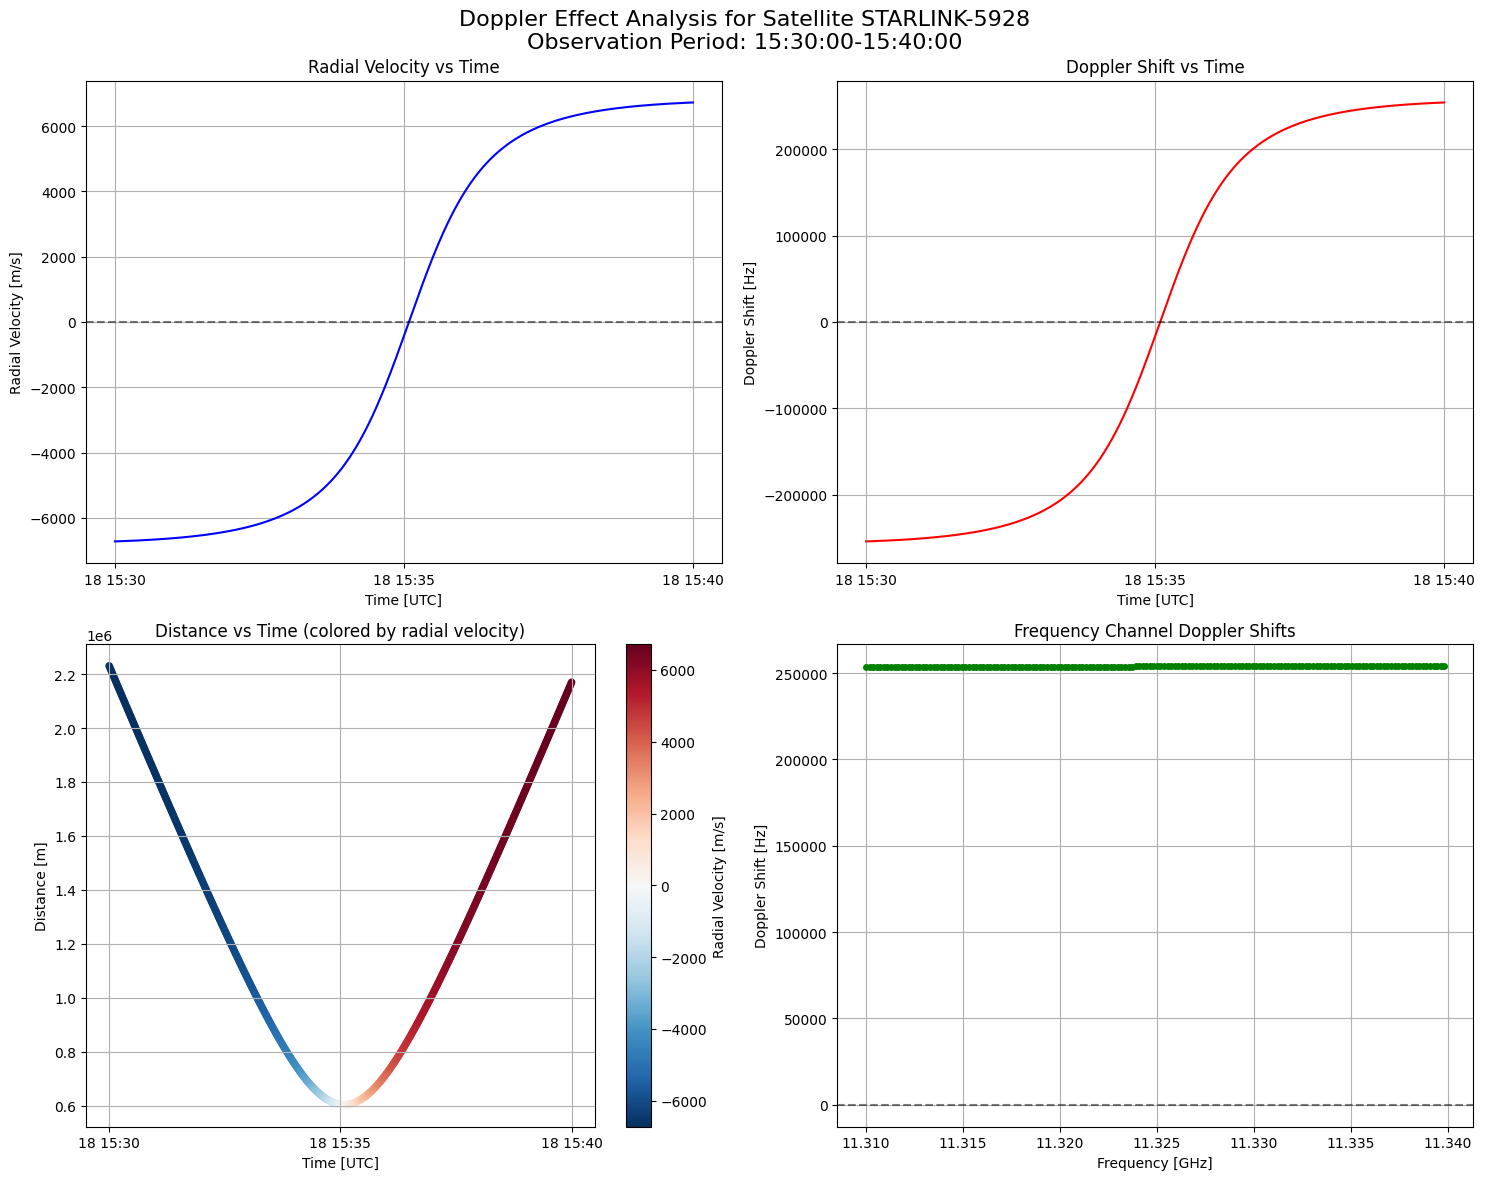

✓ Doppler effect analysis plot saved as '05_doppler_effect_analysis_standalone.png'


In [ ]:
print("\nStep 4: Creating Doppler effect visualization...")

# Get trajectory with Doppler data
traj_with_doppler = doppler_summary_single['trajectory_with_doppler']

# Create comprehensive Doppler effect plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
if used_obs_window:
    title = f'Doppler Effect Analysis for Satellite {first_sat_name}\nObservation Period: 15:30:00-15:40:00'
else:
    title = (f'Doppler Effect Analysis for Satellite {first_sat_name}\n'
             f'Full Data Range (Observation Window Not Available)')
fig.suptitle(title, fontsize=16)

# Plot 1: Radial velocity over time
ax1 = axes[0, 0]
ax1.plot(traj_with_doppler['times'], traj_with_doppler['radial_velocity'], 'b-', linewidth=1.5)
ax1.set_xlabel('Time [UTC]')
ax1.set_ylabel('Radial Velocity [m/s]')
ax1.set_title('Radial Velocity vs Time')
ax1.grid(True)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Plot 2: Doppler shift over time
ax2 = axes[0, 1]
ax2.plot(traj_with_doppler['times'], traj_with_doppler['doppler_shift'], 'r-', linewidth=1.5)
ax2.set_xlabel('Time [UTC]')
ax2.set_ylabel('Doppler Shift [Hz]')
ax2.set_title('Doppler Shift vs Time')
ax2.grid(True)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Plot 3: Distance vs time with velocity indication
ax3 = axes[1, 0]
scatter = ax3.scatter(
    traj_with_doppler['times'], traj_with_doppler['distances'],
    c=traj_with_doppler['radial_velocity'], cmap='RdBu_r', s=20
)
ax3.set_xlabel('Time [UTC]')
ax3.set_ylabel('Distance [m]')
ax3.set_title('Distance vs Time (colored by radial velocity)')
ax3.grid(True)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Radial Velocity [m/s]')

# Plot 4: Multi-channel frequency shift (if available)
ax4 = axes[1, 1]
if 'original_frequencies' in doppler_summary_multi:
    original_freqs = doppler_summary_multi['original_frequencies'] / 1e9  # Convert to GHz
    channel_shifts = doppler_summary_multi['channel_doppler_shifts']

    ax4.plot(original_freqs, channel_shifts, 'g-', linewidth=2, marker='o', markersize=4)
    ax4.set_xlabel('Frequency [GHz]')
    ax4.set_ylabel('Doppler Shift [Hz]')
    ax4.set_title('Frequency Channel Doppler Shifts')
    ax4.grid(True)
    ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
else:
    # Fallback: show fractional Doppler shift over time
    fractional_shifts = traj_with_doppler['doppler_shift'] / cent_freq
    ax4.plot(traj_with_doppler['times'], fractional_shifts, 'g-', linewidth=1.5)
    ax4.set_xlabel('Time [UTC]')
    ax4.set_ylabel('Fractional Doppler Shift')
    ax4.set_title('Fractional Doppler Shift vs Time')
    ax4.grid(True)
    ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('05_doppler_effect_analysis_standalone.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Doppler effect analysis plot saved as '05_doppler_effect_analysis_standalone.png'")


## Step 5: Multi-Satellite Analysis

We'll analyze the Doppler effect across multiple satellites to understand the statistical distribution of frequency shifts.


In [ ]:
print("\nStep 5: Analyzing Doppler effect across multiple satellites...")

# Analyze all satellites in the observation window
satellites_to_analyze = satellites_in_obs_window
max_satellites = len(satellites_to_analyze)
doppler_stats = []

print(f"Analyzing all {max_satellites} satellites in the observation window...")

for i, sat_name in enumerate(satellites_to_analyze):
    # Get satellite trajectory
    sat_data_subset = sat_data[sat_data['sat'] == sat_name].copy()

    # Filter to observation window
    sat_data_subset_obs = sat_data_subset[
        (sat_data_subset['times'] >= obs_start) &
        (sat_data_subset['times'] <= obs_stop)
    ].copy()

    if len(sat_data_subset_obs) == 0:
        print(f"    WARNING: No data for {sat_name} in observation window, skipping...")
        continue

    # Check if we have enough data points for velocity calculation (need at least 2 points)
    if len(sat_data_subset_obs) < 2:
        print(f"    WARNING: Insufficient data points ({len(sat_data_subset_obs)}) for {sat_name}, skipping...")
        continue

    # Convert to Trajectory format (using renamed columns)
    sat_traj_subset = pd.DataFrame({
        'times': sat_data_subset_obs['times'],
        'azimuths': sat_data_subset_obs['azimuths'],
        'elevations': sat_data_subset_obs['elevations'],
        'distances': sat_data_subset_obs['distances']
    })

    # Calculate Doppler effect
    doppler_summary = get_doppler_impact_on_observation(sat_traj_subset, cent_freq, bw, freq_chan)

    doppler_stats.append({
        'satellite': sat_name,
        'max_radial_velocity': doppler_summary['max_radial_velocity'],
        'max_doppler_shift': doppler_summary['max_doppler_shift'],
        'fractional_shift': doppler_summary['fractional_shift_max']
    })

# Convert to DataFrame for analysis
doppler_df = pd.DataFrame(doppler_stats)

if len(doppler_df) == 0:
    print("\nWARNING: No satellites found in the observation window!")
    print("This could mean:")
    print("  1. The observation window (15:30:00-15:40:00) doesn't match the data")
    print("  2. Satellites are filtered out by elevation or other criteria")
    print("  3. The data file covers a different time period")

    # Show the actual time range in the data
    print(f"\nActual data time range: {sat_data['times'].min()} to {sat_data['times'].max()}")
    print(f"Observation window requested: {obs_start} to {obs_stop}")

    # Try using the full data range instead
    print("\nTrying analysis with full data range...")
    doppler_stats_full = []

    for i, sat_name in enumerate(satellite_names):
        print(f"  Processing satellite {i+1}/{len(satellite_names)}: {sat_name}")

        # Get satellite trajectory (full range)
        sat_data_subset = sat_data[sat_data['sat'] == sat_name].copy()

        # Convert to Trajectory format (using renamed columns)
        sat_traj_subset = pd.DataFrame({
            'times': sat_data_subset['times'],
            'azimuths': sat_data_subset['azimuths'],
            'elevations': sat_data_subset['elevations'],
            'distances': sat_data_subset['distances']
        })

        # Calculate Doppler effect
        doppler_summary = get_doppler_impact_on_observation(sat_traj_subset, cent_freq, bw, freq_chan)

        doppler_stats_full.append({
            'satellite': sat_name,
            'max_radial_velocity': doppler_summary['max_radial_velocity'],
            'max_doppler_shift': doppler_summary['max_doppler_shift'],
            'fractional_shift': doppler_summary['fractional_shift_max']
        })

    doppler_df = pd.DataFrame(doppler_stats_full)
    print(f"\nAnalysis completed with full data range for {len(doppler_df)} satellites")

if len(doppler_df) > 0:
    print(f"\nDoppler effect statistics across {len(doppler_df)} satellites:")
    min_vel = doppler_df['max_radial_velocity'].min()
    max_vel = doppler_df['max_radial_velocity'].max()
    print(f"  Maximum radial velocity range: {min_vel:.2f} to {max_vel:.2f} m/s")
    min_shift = doppler_df['max_doppler_shift'].min()
    max_shift = doppler_df['max_doppler_shift'].max()
    print(f"  Maximum Doppler shift range: {min_shift:.2f} to {max_shift:.2f} Hz")
    min_frac = doppler_df['fractional_shift'].min()
    max_frac = doppler_df['fractional_shift'].max()
    print(f"  Maximum fractional shift range: {min_frac:.2e} to {max_frac:.2e}")
else:
    print("\nERROR: No satellite data available for analysis!")
    print("Please check the data file and time windows.")
    raise ValueError("No satellite data available for analysis")



Step 5: Analyzing Doppler effect across multiple satellites...
Analyzing all 409 satellites in the observation window...

Doppler effect statistics across 407 satellites:
  Maximum radial velocity range: 450.47 to 7271.15 m/s
  Maximum Doppler shift range: 17005.29 to 274489.36 Hz
  Maximum fractional shift range: 1.50e-06 to 2.42e-05


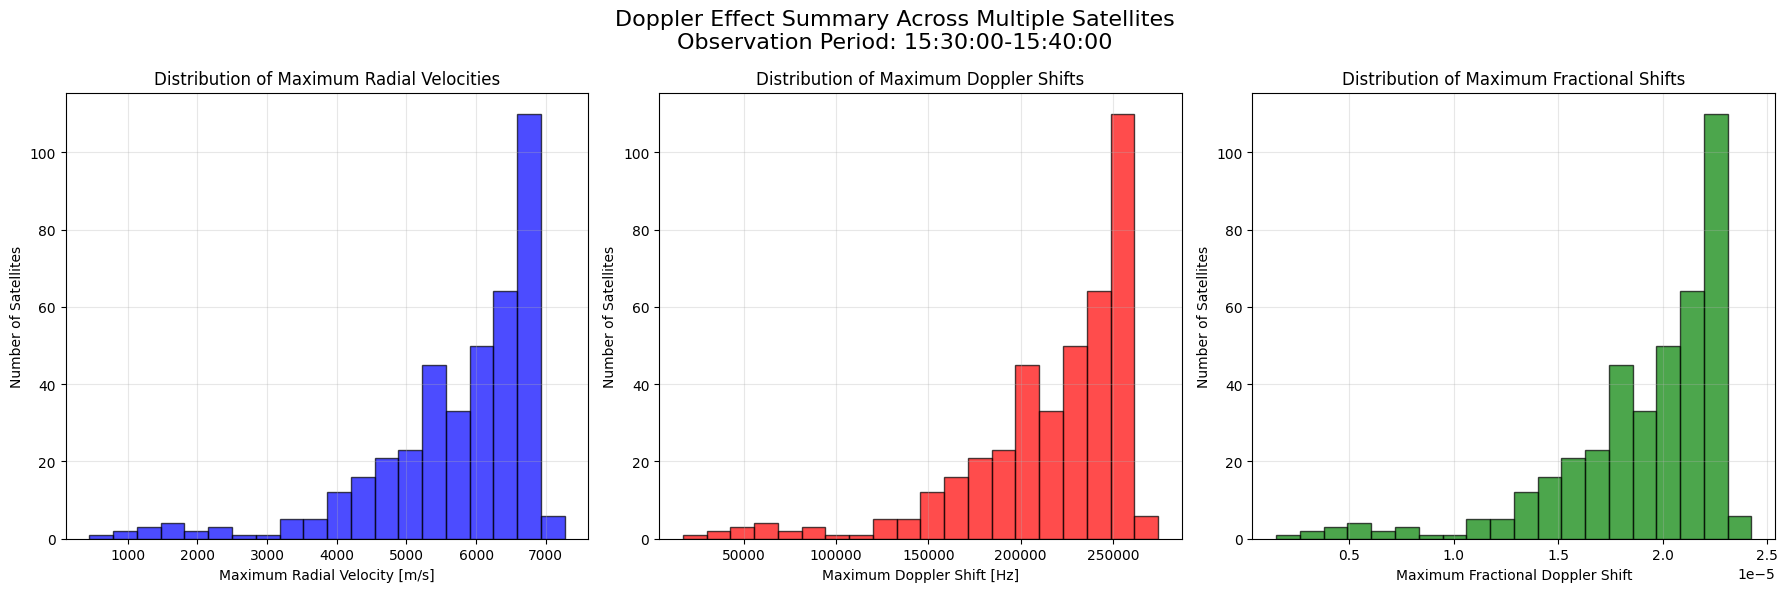

✓ Doppler effect summary plot saved as '05_doppler_effect_summary_standalone.png'


In [ ]:
# Create summary plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
if len(doppler_stats) > 0:
    # Used observation window
    plot_title = 'Doppler Effect Summary Across Multiple Satellites\nObservation Period: 15:30:00-15:40:00'
else:
    # Used full data range
    plot_title = 'Doppler Effect Summary Across Multiple Satellites\nFull Data Range (Observation Window Not Available)'
fig.suptitle(plot_title, fontsize=16)

# Plot 1: Radial velocity distribution
axes[0].hist(doppler_df['max_radial_velocity'], bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_xlabel('Maximum Radial Velocity [m/s]')
axes[0].set_ylabel('Number of Satellites')
axes[0].set_title('Distribution of Maximum Radial Velocities')
axes[0].grid(True, alpha=0.3)

# Plot 2: Doppler shift distribution
axes[1].hist(doppler_df['max_doppler_shift'], bins=20, alpha=0.7, color='red', edgecolor='black')
axes[1].set_xlabel('Maximum Doppler Shift [Hz]')
axes[1].set_ylabel('Number of Satellites')
axes[1].set_title('Distribution of Maximum Doppler Shifts')
axes[1].grid(True, alpha=0.3)

# Plot 3: Fractional shift distribution
axes[2].hist(doppler_df['fractional_shift'], bins=20, alpha=0.7, color='green', edgecolor='black')
axes[2].set_xlabel('Maximum Fractional Doppler Shift')
axes[2].set_ylabel('Number of Satellites')
axes[2].set_title('Distribution of Maximum Fractional Shifts')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_doppler_effect_summary_standalone.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Doppler effect summary plot saved as '05_doppler_effect_summary_standalone.png'")

print("\n" + "="*80)
print("DOPPLER EFFECT TEST COMPLETED")
print("="*80)


================================================================================
DOPPLER COMPENSATION: FREQUENCY-DOMAIN DOPPLER CORRECTION
================================================================================

Now we'll implement risk-based Doppler compensation strategies to improve the accuracy of radio astronomy observations.

## Step 1: Let's set up observation parameters for Doppler compensation.


In [13]:
print("\n" + "="*80)
print("DOPPLER COMPENSATION: FREQUENCY-DOMAIN DOPPLER CORRECTION")
print("="*80)

print("\nStep 1: Setting up observation parameters for Doppler compensation...")

# Define observation parameters (same as in the main tutorial)
observation_band_center = cent_freq  # 11.325 GHz
observation_band_width = 30e6  # 30 MHz

# Create telescope antenna
eta_rad = 0.45
freq_band = (10e9, 12e9)  # in Hz
file_pattern_path = os.path.join(
    os.path.dirname(os.path.abspath('__file__')), "..", "tutorial", "data", "single_cut_res.cut"
)
tel_ant = Antenna.from_file(
    file_pattern_path,
    eta_rad,
    freq_band,
    power_tag='power',
    declination_tag='alpha',
    azimuth_tag='beta'
)

# Create telescope instrument
T_phy = 300.0  # in K


def T_RX(tim, freq):
    return 80.0  # in K


coords = [42.6129479883915, -71.49379366344017, 86.7689687917009]
westford = Instrument(tel_ant, T_phy, cent_freq, bw, T_RX, freq_chan, coords)

# Create satellite antenna and instrument
sat_eta_rad = 0.5
sat_gain_max = 39.3  # in dBi
half_beamwidth = 3.0  # in deg
alphas = np.arange(0, 181)
betas = np.arange(0, 351, 10)
gain_pat = antenna_mdl_ITU(sat_gain_max, half_beamwidth, alphas, betas)
sat_ant = Antenna.from_dataframe(gain_pat, sat_eta_rad, freq_band)

# Satellite transmitter parameters
sat_T_phy = 0.0  # in K
sat_freq = 11.325e9  # in Hz
sat_bw = 250e6  # in Hz
transmit_pow = -15 + 10 * np.log10(300)  # in dBW


def transmit_temp(tim, freq):
    return power_to_temperature(10**(transmit_pow/10), 1.0)  # in K


sat_transmit = Instrument(sat_ant, sat_T_phy, sat_freq, sat_bw, transmit_temp, 1, [])

print("✓ Observation parameters set up for Doppler compensation")



DOPPLER COMPENSATION: FREQUENCY-DOMAIN DOPPLER CORRECTION

Step 1: Setting up observation parameters for Doppler compensation...
This power_pattern_from_cut_file function assumes Daniel Sheen generated files
✓ Observation parameters set up for Doppler compensation



## Step 1 continued.

In [14]:
# Create source trajectory (simplified for demonstration)
file_traj_obj_path = os.path.join(
    os.path.dirname(os.path.abspath('__file__')), "..", "tutorial", "data",
    f"casA_trajectory_Westford_{start_window_str}_{stop_window_str}.arrow"
)

if os.path.exists(file_traj_obj_path):
    traj_src = Trajectory.from_file(
        file_traj_obj_path,
        time_tag='time_stamps',
        elevation_tag='altitudes',
        azimuth_tag='azimuths',
        distance_tag='distances'
    )

    # Apply offset and create observation trajectory
    traj_obj = Trajectory(traj_src.traj.copy())
    offset_angles = (-40, 0.)  # (az,el) in degrees
    time_off_src = start_obs
    time_on_src = time_off_src + timedelta(minutes=5)

    mask = (traj_obj.traj['times'] >= time_off_src) & (traj_obj.traj['times'] <= time_on_src)
    traj_obj.traj.loc[mask, 'azimuths'] += offset_angles[0]
    traj_obj.traj.loc[mask, 'elevations'] += offset_angles[1]

    # Filter points below 5deg elevation
    filt_el = ('elevations', lambda e: e > 5.)
    observ = Observation.from_dates(start_obs, stop_obs, traj_obj, westford, filt_funcs=(filt_el,))
else:
    print("Warning: Source trajectory file not found. Creating simplified observation.")
    # Create a simple observation for demonstration
    from datetime import timedelta
    time_samples = pd.date_range(start=start_obs, end=stop_obs, freq='1min')
    traj_data = pd.DataFrame({
        'times': time_samples,
        'azimuths': [180.0] * len(time_samples),  # South
        'elevations': [45.0] * len(time_samples),  # 45 degrees elevation
        'distances': [np.inf] * len(time_samples)
    })
    traj_obj = Trajectory(traj_data)
    observ = Observation.from_dates(start_obs, stop_obs, traj_obj, westford)

# Create sky model
flux_src = estim_casA_flux(cent_freq)  # in Jy
max_gain = tel_ant.get_boresight_gain()
A_eff_max = antenna_pattern.gain_to_effective_aperture(max_gain, cent_freq)


def T_src(t):
    if t <= time_on_src:
        return 0.0
    else:
        return estim_temp(flux_src, A_eff_max)


T_gnd = 0  # no constant RFI
T_var = 0  # in K (no RFI)
T_rfi = T_gnd + T_var
T_CMB = 2.73  # in K


def T_gal(freq): return 1e-1 * (freq/1.41e9)**(-2.7)  # in K


def T_bkg(freq): return T_CMB + T_gal(freq)


T_atm_zenith = 150  # K
tau = 0.05


def T_atm(dec): return T_atm_zenith * (1 - np.exp(-tau/np.cos(dec)))  # in K


def sky_mdl(dec, caz, tim, freq):
    return T_src(tim) + T_atm(dec) + T_rfi + T_bkg(freq)

print("✓ Source trajectory and sky model created")


✓ Source trajectory and sky model created


## Step 2: Now let's perform statistical analysis for Doppler compensation decision.

In [18]:
# Run statistical analysis
print("\nStep 2: Running statistical analysis for Doppler compensation decision...")
doppler_statistics = analyze_doppler_statistics(
    sat_data, observation_band_center, observation_band_width,
    start_obs, stop_obs, cent_freq
)
print_doppler_statistical_summary(doppler_statistics, observation_band_width)

# Decision logic based on risk assessment
contamination_probability = doppler_statistics['contamination_probability']
print(f"\n🔍 RISK-BASED DECISION: Contamination probability = {contamination_probability:.1%}")

if contamination_probability > 0.4:  # Medium or High risk
    print("⚠️  MEDIUM/HIGH RISK DETECTED - Applying Doppler Correction for Physics-Based Prediction")
    use_doppler_correction = True
else:
    print("🟢 LOW RISK DETECTED - Using Standard Prediction (No Doppler Correction)")
    print("Using all satellites with standard link budget calculation")
    use_doppler_correction = False



Step 2: Running statistical analysis for Doppler compensation decision...
Running statistical analysis...

STATISTICAL ANALYSIS SUMMARY

📊 FREQUENCY CONTAMINATION ANALYSIS:
   • Contamination Probability: 20.2%
   • Average Interfering Satellites: 0.2
   • Data Integrity Score: 79.8%
   • Frequency Coverage Loss: 20.2%

🎯 DOPPLER IMPACT DISTRIBUTION:
   • High Impact (>300 kHz): 0.0%
   • Medium Impact (60-300 kHz): 95.8%
   • Low Impact (<60 kHz): 4.2%

⚠️  RISK ASSESSMENT:
   • Risk Score: 0.008
   • Recommended Strategy: Standard Observation

📈 DETAILED STATISTICS:
   • Total Satellites Analyzed: 212
   • Contaminating Satellites: 212
   • Mean Doppler Shift: 193.8 kHz
   • Max Doppler Shift: 258.5 kHz
   • Doppler Shift Std Dev: 54.2 kHz

⏰ TEMPORAL PATTERNS:
   • Average Interference Duration: 194.3 time steps
   • Peak Interference Times: 5 identified

INTERPRETATION:
🟢 LOW INTERFERENCE RISK: Standard observation should be feasible
💡 RECOMMENDATION: Standard observation approach

## Step 3: Now let's calculate radial velocities for Doppler correction.

In [21]:


# Calculate radial velocities if Doppler correction is needed
if use_doppler_correction:
    print("\nStep 3: Calculating radial velocities for Doppler correction...")

    # Filter data to observation window and elevation criteria
    obs_window_data = sat_data[
        (sat_data['times'] >= start_obs) &
        (sat_data['times'] <= stop_obs) &
        (sat_data['elevations'] > 20)
    ].copy()

    # Calculate radial velocities for all satellites
    radial_velocities = calculate_radial_velocities_vectorized(obs_window_data)

    # Add radial velocities to the data for later use
    obs_window_data['radial_velocities'] = radial_velocities

    # Calculate Doppler statistics for reporting
    max_radial_velocity = np.max(np.abs(radial_velocities)) if len(radial_velocities) > 0 else 0
    max_doppler_shift = (max_radial_velocity / 299792458) * observation_band_center

    print(f"   • Maximum radial velocity: {max_radial_velocity:.1f} m/s")
    print(f"   • Maximum Doppler shift: {max_doppler_shift/1e3:.1f} kHz")
    print(f"   • Satellites with Doppler correction: {len(obs_window_data['sat'].unique())}")

    # Store the corrected data for use in constellation loading
    doppler_corrected_data = obs_window_data
else:
    doppler_corrected_data = None


## Step 4. Let's load constellation with conditional Doppler correction.

In [22]:
# Create constellation with conditional Doppler correction
print("\nStep 4: Loading constellation with conditional Doppler correction...")

# Define filters
filt_name = ('sat', lambda s: ~s.str.contains('DTC'))
filt_el = ('elevations', lambda e: e > 20)

if use_doppler_correction:
    # Apply Doppler correction for physics-based prediction
    def lnk_bdgt_with_doppler(*args, **kwargs):
        """Link budget function with Doppler correction for physics-based prediction"""
        # Extract radial velocities from the corrected data
        # This is a simplified approach - in a full implementation,
        # we would need to map the radial velocities to the specific satellite/time combinations
        if doppler_corrected_data is not None and len(doppler_corrected_data) > 0:
            # Use average radial velocity for now (simplified approach)
            avg_radial_velocity = np.mean(doppler_corrected_data['radial_velocities'])
            return lnk_bdgt_with_doppler_correction(*args, radial_velocities=avg_radial_velocity, **kwargs)
        else:
            return sat_link_budget_vectorized(*args, **kwargs)

    starlink_constellation = Constellation.from_file(
        file_traj_sats_path, observ, sat_transmit, lnk_bdgt_with_doppler,
        name_tag='sat',
        time_tag='timestamp',
        elevation_tag='elevations',
        azimuth_tag='azimuths',
        distance_tag='ranges_westford',
        filt_funcs=(filt_name, filt_el)  # No filtering - all satellites included with correction
    )
else:
    # No Doppler correction (low risk case)
    def lnk_bdgt(*args, **kwargs):
        return sat_link_budget_vectorized(*args, **kwargs)

    starlink_constellation = Constellation.from_file(
        file_traj_sats_path, observ, sat_transmit, lnk_bdgt,
        name_tag='sat',
        time_tag='timestamp',
        elevation_tag='elevations',
        azimuth_tag='azimuths',
        distance_tag='ranges_westford',
        filt_funcs=(filt_name, filt_el)
    )

print("✓ Constellation loaded with conditional Doppler correction")



Step 4: Loading constellation with conditional Doppler correction...
✓ Constellation loaded with conditional Doppler correction


## Step 5: Let's computing result with Doppler compensation.

In [24]:
# Compute result with Doppler compensation
print("\nStep 5: Computing result with Doppler compensation...")
if use_doppler_correction:
    print("Starting result computation (with Doppler correction for physics-based prediction)...")
else:
    print("Starting result computation (standard prediction - low risk)...")

result = model_observed_temp(observ, sky_mdl, starlink_constellation)


Step 5: Computing result with Doppler compensation...
Starting result computation (standard prediction - low risk)...


## Step 6: Let's create plot of result over time...


Step 6: Creating plot of result over time...


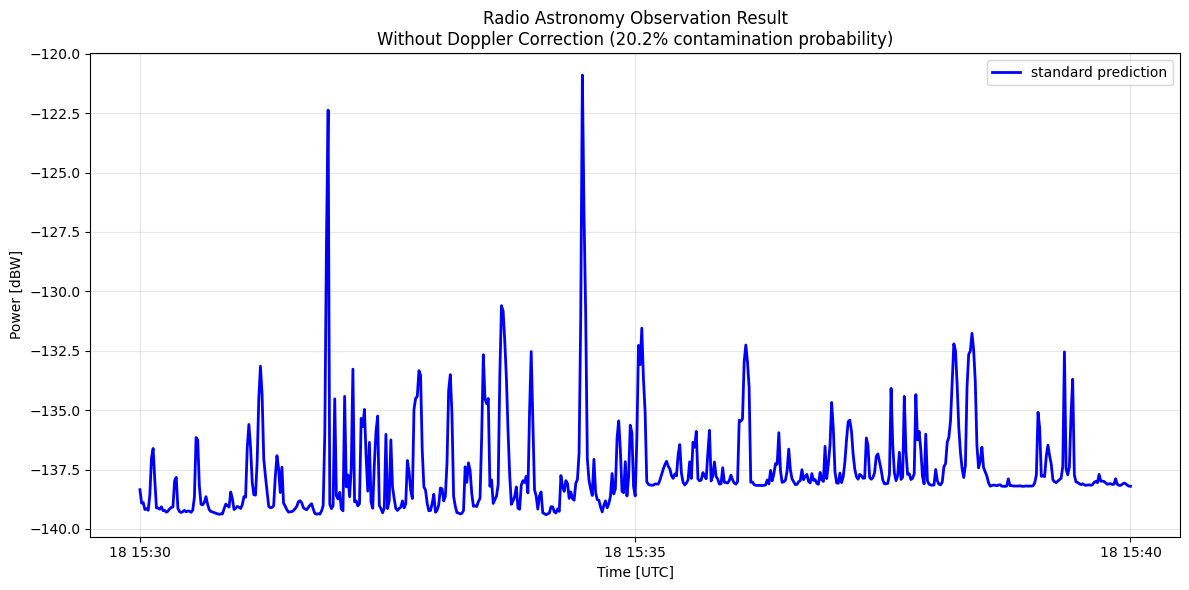


Plot saved as: 05_doppler_compensation_result.png

DOPPLER COMPENSATION TEST COMPLETED


In [26]:


# Create plot showing the result over time
print("\nStep 6: Creating plot of result over time...")


# Prevent log10 of negative values
def safe_log10(x):
    x = np.array(x)
    x = np.where(x > 0, x, np.nan)
    return np.log10(x)


fig, ax = plt.subplots(figsize=(12, 6))
time_samples = observ.get_time_stamps()

# Plot the result
plot_result = temperature_to_power(result[:, 0, 0], bw)
ax.plot(time_samples, 10 * safe_log10(plot_result),
        label="with Doppler correction" if use_doppler_correction else "standard prediction",
        linewidth=2, color='blue')

ax.legend()
ax.set_xlabel("Time [UTC]")
ax.set_ylabel("Power [dBW]")
ax.set_title(f"Radio Astronomy Observation Result\n"
             f"{'With' if use_doppler_correction else 'Without'} Doppler Correction "
             f"({contamination_probability:.1%} contamination probability)")
ax.grid(True, alpha=0.3)
fig.tight_layout()

# Save the plot
plot_filename = '05_doppler_compensation_result.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved as: {plot_filename}")

print("\n" + "="*80)
print("DOPPLER COMPENSATION TEST COMPLETED")
print("="*80)


## Summary

Congratulations! You have successfully completed Tutorial 05.


